In [ ]:

# Hybrid 3.0 Design Generation and Evaluation
# Step 1: Load required libraries and datasets

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Load the datasets
print("Loading datasets...")
hybrid_2_designs = pd.read_csv('hybrid_2.0_designs.csv')
known_binders = []
with open('known_niv_binders_full.fasta', 'r') as f:
    for line in f:
        if not line.startswith('>'):
            known_binders.append(line.strip())

cdr_library = pd.read_csv('cdr_library_summary.csv')
allosteric_cdr = pd.read_csv('allosteric_cdr_library.csv')

print(f"Hybrid 2.0 designs loaded: {len(hybrid_2_designs)} rows")
print(f"Known binders sequences: {len(known_binders)}")
print(f"CDR library entries: {len(cdr_library)}")
print(f"Allosteric CDR library entries: {len(allosteric_cdr)}")
print("\nHybrid 2.0 columns:", hybrid_2_designs.columns.tolist())
print("\nFirst few rows of Hybrid 2.0 designs:")
print(hybrid_2_designs.head())


Loading datasets...
Hybrid 2.0 designs loaded: 44343 rows
Known binders sequences: 25
CDR library entries: 12
Allosteric CDR library entries: 21

Hybrid 2.0 columns: ['Scaffold', 'Loop_Position', 'Loop_Range', 'Parent_Subsequence', 'Double_Mutant_Sequence', 'Mutations', 'Design_Sequence', 'Motif_MJ_Score', 'Motif_Length']

First few rows of Hybrid 2.0 designs:
  Scaffold  Loop_Position Loop_Range Parent_Subsequence  \
0     1FNA              1      25-33          RASQGIIDY   
1     1FNA              2      40-48          RASQGIIDY   
2     1FNA              3      60-68          RASQGIIDY   
3     1TEN              1      15-23          RASQGIIDY   
4     1TEN              2      40-48          RASQGIIDY   

  Double_Mutant_Sequence Mutations  \
0              QSSQGIIDY   R1Q,A2S   
1              QSSQGIIDY   R1Q,A2S   
2              QSSQGIIDY   R1Q,A2S   
3              QSSQGIIDY   R1Q,A2S   
4              QSSQGIIDY   R1Q,A2S   

                                     Design_Sequence 

In [ ]:

# Step 2: Identify top 10 unique double-mutant subsequences by raw MJ score
# Most negative scores are best

# Get unique subsequences with their best scores
unique_motifs = hybrid_2_designs.groupby('Double_Mutant_Sequence').agg({
    'Motif_MJ_Score': 'min',  # Most negative (best)
    'Parent_Subsequence': 'first',
    'Mutations': 'first',
    'Motif_Length': 'first'
}).reset_index()

# Sort by score (most negative first)
unique_motifs_sorted = unique_motifs.sort_values('Motif_MJ_Score')

print(f"Total unique double-mutant subsequences: {len(unique_motifs)}")
print("\nTop 10 double-mutant motifs by raw MJ score (most negative = best):")
top_10_motifs = unique_motifs_sorted.head(10)
print(top_10_motifs.to_string())

# Store for later use
top_10_sequences = top_10_motifs['Double_Mutant_Sequence'].tolist()
print("\n" + "="*80)
print("Top 10 sequences to mutate:")
for i, seq in enumerate(top_10_sequences, 1):
    print(f"{i}. {seq}")


Total unique double-mutant subsequences: 4927

Top 10 double-mutant motifs by raw MJ score (most negative = best):
     Double_Mutant_Sequence  Motif_MJ_Score Parent_Subsequence Mutations  Motif_Length
4468              VHDFGIAFM         -130.06          VHDYGISFM   Y4F,S7A             9
4490              VHDWGIAFM         -129.92          VHDYGISFM   Y4W,S7A             9
4612              VYDWGISFM         -129.54          VHDYGISFM   H2Y,Y4W             9
4610              VYDFGISFM         -129.46          VHDYGISFM   H2Y,Y4F             9
1985              LHDWGISFM         -128.58          VHDYGISFM   V1L,Y4W             9
1983              LHDFGISFM         -128.51          VHDYGISFM   V1L,Y4F             9
4475              VHDFGITFM         -128.29          VHDYGISFM   Y4F,S7T             9
4497              VHDWGITFM         -128.26          VHDYGISFM   Y4W,S7T             9
2073              MHDWGISFM         -127.80          VHDYGISFM   V1M,Y4W             9
2071           

In [ ]:

# Step 3: Load BLOSUM62 matrix for conservative mutations
# Define BLOSUM62 matrix (simplified version with common amino acids)

blosum62 = {
    'A': {'A': 4, 'R': -1, 'N': -2, 'D': -2, 'C': 0, 'Q': -1, 'E': -1, 'G': 0, 'H': -2, 'I': -1, 'L': -1, 'K': -1, 'M': -1, 'F': -2, 'P': -1, 'S': 1, 'T': 0, 'W': -3, 'Y': -2, 'V': 0},
    'R': {'A': -1, 'R': 5, 'N': 0, 'D': -2, 'C': -3, 'Q': 1, 'E': 0, 'G': -2, 'H': 0, 'I': -3, 'L': -2, 'K': 2, 'M': -1, 'F': -3, 'P': -2, 'S': -1, 'T': -1, 'W': -3, 'Y': -2, 'V': -3},
    'N': {'A': -2, 'R': 0, 'N': 6, 'D': 1, 'C': -3, 'Q': 0, 'E': 0, 'G': 0, 'H': 1, 'I': -3, 'L': -3, 'K': 0, 'M': -2, 'F': -3, 'P': -2, 'S': 1, 'T': 0, 'W': -4, 'Y': -2, 'V': -3},
    'D': {'A': -2, 'R': -2, 'N': 1, 'D': 6, 'C': -3, 'Q': 0, 'E': 2, 'G': -1, 'H': -1, 'I': -3, 'L': -4, 'K': -1, 'M': -3, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -4, 'Y': -3, 'V': -3},
    'C': {'A': 0, 'R': -3, 'N': -3, 'D': -3, 'C': 9, 'Q': -3, 'E': -4, 'G': -3, 'H': -3, 'I': -1, 'L': -1, 'K': -3, 'M': -1, 'F': -2, 'P': -3, 'S': -1, 'T': -1, 'W': -2, 'Y': -2, 'V': -1},
    'Q': {'A': -1, 'R': 1, 'N': 0, 'D': 0, 'C': -3, 'Q': 5, 'E': 2, 'G': -2, 'H': 0, 'I': -3, 'L': -2, 'K': 1, 'M': 0, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -2, 'Y': -1, 'V': -2},
    'E': {'A': -1, 'R': 0, 'N': 0, 'D': 2, 'C': -4, 'Q': 2, 'E': 5, 'G': -2, 'H': 0, 'I': -3, 'L': -3, 'K': 1, 'M': -2, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -3, 'Y': -2, 'V': -2},
    'G': {'A': 0, 'R': -2, 'N': 0, 'D': -1, 'C': -3, 'Q': -2, 'E': -2, 'G': 6, 'H': -2, 'I': -4, 'L': -4, 'K': -2, 'M': -3, 'F': -3, 'P': -2, 'S': 0, 'T': -2, 'W': -2, 'Y': -3, 'V': -3},
    'H': {'A': -2, 'R': 0, 'N': 1, 'D': -1, 'C': -3, 'Q': 0, 'E': 0, 'G': -2, 'H': 8, 'I': -3, 'L': -3, 'K': -1, 'M': -2, 'F': -1, 'P': -2, 'S': -1, 'T': -2, 'W': -2, 'Y': 2, 'V': -3},
    'I': {'A': -1, 'R': -3, 'N': -3, 'D': -3, 'C': -1, 'Q': -3, 'E': -3, 'G': -4, 'H': -3, 'I': 4, 'L': 2, 'K': -3, 'M': 1, 'F': 0, 'P': -3, 'S': -2, 'T': -1, 'W': -3, 'Y': -1, 'V': 3},
    'L': {'A': -1, 'R': -2, 'N': -3, 'D': -4, 'C': -1, 'Q': -2, 'E': -3, 'G': -4, 'H': -3, 'I': 2, 'L': 4, 'K': -2, 'M': 2, 'F': 0, 'P': -3, 'S': -2, 'T': -1, 'W': -2, 'Y': -1, 'V': 1},
    'K': {'A': -1, 'R': 2, 'N': 0, 'D': -1, 'C': -3, 'Q': 1, 'E': 1, 'G': -2, 'H': -1, 'I': -3, 'L': -2, 'K': 5, 'M': -1, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -3, 'Y': -2, 'V': -2},
    'M': {'A': -1, 'R': -1, 'N': -2, 'D': -3, 'C': -1, 'Q': 0, 'E': -2, 'G': -3, 'H': -2, 'I': 1, 'L': 2, 'K': -1, 'M': 5, 'F': 0, 'P': -2, 'S': -1, 'T': -1, 'W': -1, 'Y': -1, 'V': 1},
    'F': {'A': -2, 'R': -3, 'N': -3, 'D': -3, 'C': -2, 'Q': -3, 'E': -3, 'G': -3, 'H': -1, 'I': 0, 'L': 0, 'K': -3, 'M': 0, 'F': 6, 'P': -4, 'S': -2, 'T': -2, 'W': 1, 'Y': 3, 'V': -1},
    'P': {'A': -1, 'R': -2, 'N': -2, 'D': -1, 'C': -3, 'Q': -1, 'E': -1, 'G': -2, 'H': -2, 'I': -3, 'L': -3, 'K': -1, 'M': -2, 'F': -4, 'P': 7, 'S': -1, 'T': -1, 'W': -4, 'Y': -3, 'V': -2},
    'S': {'A': 1, 'R': -1, 'N': 1, 'D': 0, 'C': -1, 'Q': 0, 'E': 0, 'G': 0, 'H': -1, 'I': -2, 'L': -2, 'K': 0, 'M': -1, 'F': -2, 'P': -1, 'S': 4, 'T': 1, 'W': -3, 'Y': -2, 'V': -2},
    'T': {'A': 0, 'R': -1, 'N': 0, 'D': -1, 'C': -1, 'Q': -1, 'E': -1, 'G': -2, 'H': -2, 'I': -1, 'L': -1, 'K': -1, 'M': -1, 'F': -2, 'P': -1, 'S': 1, 'T': 5, 'W': -2, 'Y': -2, 'V': 0},
    'W': {'A': -3, 'R': -3, 'N': -4, 'D': -4, 'C': -2, 'Q': -2, 'E': -3, 'G': -2, 'H': -2, 'I': -3, 'L': -2, 'K': -3, 'M': -1, 'F': 1, 'P': -4, 'S': -3, 'T': -2, 'W': 11, 'Y': 2, 'V': -3},
    'Y': {'A': -2, 'R': -2, 'N': -2, 'D': -3, 'C': -2, 'Q': -1, 'E': -2, 'G': -3, 'H': 2, 'I': -1, 'L': -1, 'K': -2, 'M': -1, 'F': 3, 'P': -3, 'S': -2, 'T': -2, 'W': 2, 'Y': 7, 'V': -1},
    'V': {'A': 0, 'R': -3, 'N': -3, 'D': -3, 'C': -1, 'Q': -2, 'E': -2, 'G': -3, 'H': -3, 'I': 3, 'L': 1, 'K': -2, 'M': 1, 'F': -1, 'P': -2, 'S': -2, 'T': 0, 'W': -3, 'Y': -1, 'V': 4}
}

def is_conservative(original_aa, new_aa):
    """Check if a mutation is conservative (BLOSUM62 score > 0)"""
    if original_aa not in blosum62 or new_aa not in blosum62[original_aa]:
        return False
    return blosum62[original_aa][new_aa] > 0

print("BLOSUM62 matrix loaded successfully")
print("\nExample conservative mutations for V:")
for aa, score in blosum62['V'].items():
    if score > 0:
        print(f"  V -> {aa}: score = {score}")


BLOSUM62 matrix loaded successfully

Example conservative mutations for V:
  V -> I: score = 3
  V -> L: score = 1
  V -> M: score = 1
  V -> V: score = 4


In [ ]:

# Step 4: Identify already-mutated positions for each top 10 motif
# Parse the mutations from the original Hybrid 2.0 data

def parse_mutations(mutation_str):
    """Parse mutation string like 'Y4F,S7A' to get positions (0-indexed)"""
    positions = []
    for mut in mutation_str.split(','):
        # Extract position number (1-indexed in string, convert to 0-indexed)
        pos = int(''.join([c for c in mut if c.isdigit()]))
        positions.append(pos - 1)  # Convert to 0-indexed
    return positions

# For each top 10 motif, get the parent sequence and mutation positions
print("Analyzing mutation positions for top 10 motifs:")
print("="*80)

top_10_info = []
for idx, row in top_10_motifs.iterrows():
    double_mut_seq = row['Double_Mutant_Sequence']
    parent_seq = row['Parent_Subsequence']
    mutations = row['Mutations']
    
    mutated_positions = parse_mutations(mutations)
    
    # Available positions for third mutation (not already mutated)
    available_positions = [i for i in range(len(double_mut_seq)) if i not in mutated_positions]
    
    info = {
        'double_mutant': double_mut_seq,
        'parent': parent_seq,
        'mutations': mutations,
        'mutated_positions': mutated_positions,
        'available_positions': available_positions
    }
    top_10_info.append(info)
    
    print(f"\nMotif: {double_mut_seq}")
    print(f"  Parent: {parent_seq}")
    print(f"  Mutations: {mutations}")
    print(f"  Already mutated positions (0-indexed): {mutated_positions}")
    print(f"  Available positions for 3rd mutation: {available_positions}")


Analyzing mutation positions for top 10 motifs:

Motif: VHDFGIAFM
  Parent: VHDYGISFM
  Mutations: Y4F,S7A
  Already mutated positions (0-indexed): [3, 6]
  Available positions for 3rd mutation: [0, 1, 2, 4, 5, 7, 8]

Motif: VHDWGIAFM
  Parent: VHDYGISFM
  Mutations: Y4W,S7A
  Already mutated positions (0-indexed): [3, 6]
  Available positions for 3rd mutation: [0, 1, 2, 4, 5, 7, 8]

Motif: VYDWGISFM
  Parent: VHDYGISFM
  Mutations: H2Y,Y4W
  Already mutated positions (0-indexed): [1, 3]
  Available positions for 3rd mutation: [0, 2, 4, 5, 6, 7, 8]

Motif: VYDFGISFM
  Parent: VHDYGISFM
  Mutations: H2Y,Y4F
  Already mutated positions (0-indexed): [1, 3]
  Available positions for 3rd mutation: [0, 2, 4, 5, 6, 7, 8]

Motif: LHDWGISFM
  Parent: VHDYGISFM
  Mutations: V1L,Y4W
  Already mutated positions (0-indexed): [0, 3]
  Available positions for 3rd mutation: [1, 2, 4, 5, 6, 7, 8]

Motif: LHDFGISFM
  Parent: VHDYGISFM
  Mutations: V1L,Y4F
  Already mutated positions (0-indexed): [0, 3]


In [ ]:

# Step 5: Generate all triple-mutant variants for each top 10 motif
# For each available position, generate all conservative mutations

triple_mutant_variants = []

print("Generating triple-mutant variants...")
print("="*80)

for info in top_10_info:
    double_mut_seq = info['double_mutant']
    parent_seq = info['parent']
    mutations_str = info['mutations']
    available_positions = info['available_positions']
    
    print(f"\nProcessing motif: {double_mut_seq}")
    variants_count = 0
    
    # For each available position, try all conservative mutations
    for pos in available_positions:
        original_aa = double_mut_seq[pos]
        
        # Try all 20 amino acids
        for new_aa in blosum62.keys():
            # Skip if same as original
            if new_aa == original_aa:
                continue
            
            # Check if conservative
            if is_conservative(original_aa, new_aa):
                # Create the triple mutant sequence
                triple_mut_seq = list(double_mut_seq)
                triple_mut_seq[pos] = new_aa
                triple_mut_seq = ''.join(triple_mut_seq)
                
                # Create mutation descriptor (1-indexed for output)
                third_mutation = f"{original_aa}{pos+1}{new_aa}"
                all_mutations = f"{mutations_str},{third_mutation}"
                
                variant = {
                    'Parent_Subsequence': parent_seq,
                    'Double_Mutant_Sequence': double_mut_seq,
                    'Triple_Mutant_Sequence': triple_mut_seq,
                    'Mutations': all_mutations,
                    'Third_Mutation': third_mutation,
                    'Motif_Length': len(triple_mut_seq)
                }
                triple_mutant_variants.append(variant)
                variants_count += 1
    
    print(f"  Generated {variants_count} conservative triple-mutant variants")

print(f"\n{'='*80}")
print(f"Total triple-mutant variants generated: {len(triple_mutant_variants)}")
print("\nFirst 5 variants:")
for i, var in enumerate(triple_mutant_variants[:5]):
    print(f"{i+1}. {var['Triple_Mutant_Sequence']} (from {var['Double_Mutant_Sequence']}, mutation: {var['Third_Mutation']})")


Generating triple-mutant variants...

Processing motif: VHDFGIAFM
  Generated 15 conservative triple-mutant variants

Processing motif: VHDWGIAFM
  Generated 15 conservative triple-mutant variants

Processing motif: VYDWGISFM
  Generated 16 conservative triple-mutant variants

Processing motif: VYDFGISFM
  Generated 16 conservative triple-mutant variants

Processing motif: LHDWGISFM
  Generated 15 conservative triple-mutant variants

Processing motif: LHDFGISFM
  Generated 15 conservative triple-mutant variants

Processing motif: VHDFGITFM
  Generated 15 conservative triple-mutant variants

Processing motif: VHDWGITFM
  Generated 15 conservative triple-mutant variants

Processing motif: MHDWGISFM
  Generated 15 conservative triple-mutant variants

Processing motif: MHDFGISFM
  Generated 15 conservative triple-mutant variants

Total triple-mutant variants generated: 152

First 5 variants:
1. IHDFGIAFM (from VHDFGIAFM, mutation: V1I)
2. LHDFGIAFM (from VHDFGIAFM, mutation: V1L)
3. MHDFGI

In [ ]:

# Step 6: Apply 10-AA novelty filter
# Check all triple-mutant sequences against the comprehensive databases

def get_all_10mers(sequence):
    """Extract all 10-amino-acid subsequences from a sequence"""
    if len(sequence) < 10:
        return []
    return [sequence[i:i+10] for i in range(len(sequence) - 9)]

# Build comprehensive set of all 10-mers from known sequences
known_10mers = set()

# From known_binders_full.fasta
for seq in known_binders:
    known_10mers.update(get_all_10mers(seq))

# From cdr_library_summary.csv
for seq in cdr_library['Sequence'].values:
    known_10mers.update(get_all_10mers(seq))

# From allosteric_cdr_library.csv
for seq in allosteric_cdr['Sequence'].values:
    known_10mers.update(get_all_10mers(seq))

print(f"Total unique 10-mers in novelty database: {len(known_10mers)}")

# Check each triple-mutant variant
novel_variants = []
rejected_variants = []

print("\nApplying novelty filter to triple-mutant variants...")
for variant in triple_mutant_variants:
    seq = variant['Triple_Mutant_Sequence']
    seq_10mers = get_all_10mers(seq)
    
    # Check if any 10-mer matches known sequences
    is_novel = True
    if seq_10mers:  # Only check if sequence has 10-mers
        for mer in seq_10mers:
            if mer in known_10mers:
                is_novel = False
                break
    
    if is_novel:
        novel_variants.append(variant)
    else:
        rejected_variants.append(variant)

print(f"\nNovelty filter results:")
print(f"  Novel variants (passed): {len(novel_variants)}")
print(f"  Rejected variants (failed): {len(rejected_variants)}")
print(f"  Pass rate: {100 * len(novel_variants) / len(triple_mutant_variants):.2f}%")


Total unique 10-mers in novelty database: 832

Applying novelty filter to triple-mutant variants...

Novelty filter results:
  Novel variants (passed): 152
  Rejected variants (failed): 0
  Pass rate: 100.00%


In [ ]:

# Step 7: Load scaffold templates and define loop positions
# We'll use the three standard scaffolds: 1FNA, 1TEN, 2QMT

# Extract scaffold sequences from Hybrid 2.0 designs
scaffolds_info = {}
for scaffold in ['1FNA', '1TEN', '2QMT']:
    scaffold_data = hybrid_2_designs[hybrid_2_designs['Scaffold'] == scaffold]
    if len(scaffold_data) > 0:
        # Get a sample design sequence
        sample_design = scaffold_data.iloc[0]['Design_Sequence']
        loop_range = scaffold_data.iloc[0]['Loop_Range']
        
        scaffolds_info[scaffold] = {
            'example_sequence': sample_design,
            'example_loop_range': loop_range
        }

print("Scaffold information extracted:")
for scaffold, info in scaffolds_info.items():
    print(f"\n{scaffold}:")
    print(f"  Example sequence length: {len(info['example_sequence'])}")
    print(f"  Example loop range: {info['example_loop_range']}")

# Define the three loop positions used in Hybrid 2.0
# These are the validated loop positions from the dataset
loop_positions = {
    '1FNA': [1, 2, 3],
    '1TEN': [1, 2, 3],
    '2QMT': [1, 2, 3]
}

print("\nLoop positions to use:")
print(loop_positions)


Scaffold information extracted:

1FNA:
  Example sequence length: 90
  Example loop range: 25-33

1TEN:
  Example sequence length: 89
  Example loop range: 15-23

2QMT:
  Example sequence length: 55
  Example loop range: 15-23

Loop positions to use:
{'1FNA': [1, 2, 3], '1TEN': [1, 2, 3], '2QMT': [1, 2, 3]}


In [ ]:

# Step 8: Extract scaffold base sequences and loop ranges
# We need to systematically extract the grafting logic from Hybrid 2.0

# For each scaffold and loop position combination, extract the template
scaffold_templates = {}

for scaffold in ['1FNA', '1TEN', '2QMT']:
    scaffold_templates[scaffold] = {}
    for loop_pos in [1, 2, 3]:
        # Find matching entries
        matches = hybrid_2_designs[
            (hybrid_2_designs['Scaffold'] == scaffold) & 
            (hybrid_2_designs['Loop_Position'] == loop_pos)
        ]
        
        if len(matches) > 0:
            # Get the first match to extract template info
            example = matches.iloc[0]
            loop_range = example['Loop_Range']
            design_seq = example['Design_Sequence']
            parent_seq = example['Parent_Subsequence']
            
            # Parse loop range (e.g., "25-33" -> start=25, end=33)
            start, end = map(int, loop_range.split('-'))
            
            scaffold_templates[scaffold][loop_pos] = {
                'loop_range': loop_range,
                'loop_start': start,
                'loop_end': end,
                'template_sequence': design_seq,
                'example_motif': parent_seq
            }

print("Scaffold templates extracted:")
for scaffold, loops in scaffold_templates.items():
    print(f"\n{scaffold}:")
    for loop_pos, info in loops.items():
        print(f"  Loop {loop_pos}: positions {info['loop_range']}")


Scaffold templates extracted:

1FNA:
  Loop 1: positions 25-33
  Loop 2: positions 40-48
  Loop 3: positions 60-68

1TEN:
  Loop 1: positions 15-23
  Loop 2: positions 40-48
  Loop 3: positions 55-63

2QMT:
  Loop 1: positions 15-23
  Loop 2: positions 30-38
  Loop 3: positions 45-53


In [ ]:

# Step 9: Generate full protein designs by grafting triple-mutants into scaffolds
# We need to extract the base scaffold sequences without the motifs

def extract_base_scaffold(template_sequence, loop_start, loop_end, example_motif_length):
    """
    Extract the base scaffold sequence by removing the grafted motif.
    The loop_start and loop_end are 1-indexed positions from the documentation.
    """
    # Convert to 0-indexed
    start_idx = loop_start - 1
    end_idx = loop_end  # end is inclusive in the range notation, so this works out
    
    # Extract the prefix and suffix around the loop region
    prefix = template_sequence[:start_idx]
    suffix = template_sequence[end_idx:]
    
    return prefix, suffix

# Build scaffold base templates
scaffold_bases = {}
for scaffold in ['1FNA', '1TEN', '2QMT']:
    scaffold_bases[scaffold] = {}
    for loop_pos in [1, 2, 3]:
        info = scaffold_templates[scaffold][loop_pos]
        prefix, suffix = extract_base_scaffold(
            info['template_sequence'],
            info['loop_start'],
            info['loop_end'],
            len(info['example_motif'])
        )
        scaffold_bases[scaffold][loop_pos] = {
            'prefix': prefix,
            'suffix': suffix,
            'loop_range': info['loop_range']
        }

print("Base scaffold templates extracted:")
for scaffold, loops in scaffold_bases.items():
    print(f"\n{scaffold}:")
    for loop_pos, base in loops.items():
        print(f"  Loop {loop_pos}: prefix={len(base['prefix'])} aa, suffix={len(base['suffix'])} aa")


Base scaffold templates extracted:

1FNA:
  Loop 1: prefix=24 aa, suffix=57 aa
  Loop 2: prefix=39 aa, suffix=42 aa
  Loop 3: prefix=59 aa, suffix=22 aa

1TEN:
  Loop 1: prefix=14 aa, suffix=66 aa
  Loop 2: prefix=39 aa, suffix=41 aa
  Loop 3: prefix=54 aa, suffix=26 aa

2QMT:
  Loop 1: prefix=14 aa, suffix=32 aa
  Loop 2: prefix=29 aa, suffix=17 aa
  Loop 3: prefix=44 aa, suffix=2 aa


In [ ]:

# Step 10: Generate full protein designs for all novel triple-mutant variants
# Graft each variant into all scaffold/loop combinations

full_designs = []

print("Generating full protein designs...")
print("="*80)

for variant in novel_variants:
    triple_mut_seq = variant['Triple_Mutant_Sequence']
    
    # Graft into each scaffold at each loop position
    for scaffold in ['1FNA', '1TEN', '2QMT']:
        for loop_pos in [1, 2, 3]:
            base = scaffold_bases[scaffold][loop_pos]
            
            # Create full design by concatenating prefix + motif + suffix
            full_sequence = base['prefix'] + triple_mut_seq + base['suffix']
            
            design = {
                'Scaffold': scaffold,
                'Loop_Position': loop_pos,
                'Loop_Range': base['loop_range'],
                'Parent_Subsequence': variant['Parent_Subsequence'],
                'Double_Mutant_Sequence': variant['Double_Mutant_Sequence'],
                'Triple_Mutant_Sequence': triple_mut_seq,
                'Mutations': variant['Mutations'],
                'Third_Mutation': variant['Third_Mutation'],
                'Design_Sequence': full_sequence,
                'Motif_Length': variant['Motif_Length']
            }
            full_designs.append(design)

print(f"Total full designs generated: {len(full_designs)}")
print(f"  = {len(novel_variants)} motifs × 3 scaffolds × 3 loop positions")
print("\nFirst 3 designs:")
for i, design in enumerate(full_designs[:3]):
    print(f"\n{i+1}. Scaffold: {design['Scaffold']}, Loop: {design['Loop_Position']}")
    print(f"   Motif: {design['Triple_Mutant_Sequence']}")
    print(f"   Full sequence length: {len(design['Design_Sequence'])} aa")


Generating full protein designs...
Total full designs generated: 1368
  = 152 motifs × 3 scaffolds × 3 loop positions

First 3 designs:

1. Scaffold: 1FNA, Loop: 1
   Motif: IHDFGIAFM
   Full sequence length: 90 aa

2. Scaffold: 1FNA, Loop: 2
   Motif: IHDFGIAFM
   Full sequence length: 90 aa

3. Scaffold: 1FNA, Loop: 3
   Motif: IHDFGIAFM
   Full sequence length: 90 aa


In [ ]:

# Step 11: Load the allosteric epitope sequence (full 413-residue sequence from 2VSM chain A)
# Extract from the PDB file

from Bio import SeqIO
from Bio.PDB import PDBParser

# Try to extract sequence from PDB file
parser = PDBParser(QUIET=True)
structure = parser.get_structure('2VSM', '2VSM.pdb')

# Get chain A sequence
chain_a_seq = None
for model in structure:
    for chain in model:
        if chain.id == 'A':
            # Extract sequence from residues
            residues = [res for res in chain if res.id[0] == ' ']  # Standard residues only
            # Get the amino acid sequence
            aa_seq = []
            for res in residues:
                resname = res.get_resname()
                # Convert 3-letter to 1-letter code
                aa_map = {
                    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
                    'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
                    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
                    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
                }
                if resname in aa_map:
                    aa_seq.append(aa_map[resname])
            chain_a_seq = ''.join(aa_seq)
            break
    if chain_a_seq:
        break

print(f"Chain A sequence extracted from 2VSM.pdb:")
print(f"Length: {len(chain_a_seq)} residues")
print(f"First 50 residues: {chain_a_seq[:50]}")
print(f"Last 50 residues: {chain_a_seq[-50:]}")

# Store the allosteric epitope (full chain A sequence for consistency)
allosteric_epitope = chain_a_seq


Chain A sequence extracted from 2VSM.pdb:
Length: 413 residues
First 50 residues: ICLQKTSNQILKPKLISYTLGQSGTCITDPLLAMDEGYFAYSHLERIGSC
Last 50 residues: EDTNAQKTITNCFLLKNKIWCISLVEIYDTGDNVIRPKLFAVKIPEQCTH


In [ ]:

# Step 12: Calculate Miyazawa-Jernigan (MJ) interaction scores
# Load the MJ matrix for pairwise interaction potentials

# Miyazawa-Jernigan contact potential matrix (in kT units)
mj_matrix = {
    'A': {'A': -0.30, 'C': -0.11, 'D': -0.18, 'E': -0.40, 'F': -0.83, 'G': -0.31, 'H': -0.13, 'I': -0.44, 'K': -0.12, 'L': -0.57, 'M': -0.52, 'N': -0.14, 'P': -0.26, 'Q': -0.07, 'R': 0.04, 'S': -0.10, 'T': -0.04, 'V': -0.39, 'W': -0.24, 'Y': -0.27},
    'C': {'A': -0.11, 'C': -0.66, 'D': 0.14, 'E': -0.60, 'F': -0.68, 'G': 0.00, 'H': -0.25, 'I': -0.48, 'K': 0.10, 'L': -0.91, 'M': -0.95, 'N': 0.18, 'P': -0.53, 'Q': -0.36, 'R': -0.21, 'S': 0.13, 'T': 0.11, 'V': -0.48, 'W': -0.36, 'Y': -0.49},
    'D': {'A': -0.18, 'C': 0.14, 'D': -0.11, 'E': -0.49, 'F': -0.81, 'G': -0.17, 'H': -0.39, 'I': -0.66, 'K': -0.04, 'L': -0.69, 'M': -0.63, 'N': -0.18, 'P': -0.41, 'Q': -0.33, 'R': -0.25, 'S': -0.22, 'T': -0.29, 'V': -0.63, 'W': -0.48, 'Y': -0.39},
    'E': {'A': -0.40, 'C': -0.60, 'D': -0.49, 'E': -0.87, 'F': -0.97, 'G': -0.51, 'H': -0.62, 'I': -0.75, 'K': -0.52, 'L': -0.66, 'M': -0.59, 'N': -0.44, 'P': -0.76, 'Q': -0.52, 'R': -0.33, 'S': -0.43, 'T': -0.52, 'V': -0.61, 'W': -0.62, 'Y': -0.50},
    'F': {'A': -0.83, 'C': -0.68, 'D': -0.81, 'E': -0.97, 'F': -1.85, 'G': -0.69, 'H': -0.77, 'I': -1.29, 'K': -0.63, 'L': -1.41, 'M': -1.30, 'N': -0.72, 'P': -0.93, 'Q': -0.86, 'R': -0.43, 'S': -0.65, 'T': -0.71, 'V': -1.07, 'W': -1.16, 'Y': -1.39},
    'G': {'A': -0.31, 'C': 0.00, 'D': -0.17, 'E': -0.51, 'F': -0.69, 'G': -0.43, 'H': -0.37, 'I': -0.50, 'K': -0.23, 'L': -0.59, 'M': -0.48, 'N': -0.25, 'P': -0.38, 'Q': -0.35, 'R': -0.18, 'S': -0.16, 'T': -0.19, 'V': -0.38, 'W': -0.52, 'Y': -0.47},
    'H': {'A': -0.13, 'C': -0.25, 'D': -0.39, 'E': -0.62, 'F': -0.77, 'G': -0.37, 'H': -0.87, 'I': -0.50, 'K': -0.12, 'L': -0.71, 'M': -0.66, 'N': -0.28, 'P': -0.25, 'Q': -0.48, 'R': -0.08, 'S': -0.22, 'T': -0.26, 'V': -0.43, 'W': -0.40, 'Y': -0.73},
    'I': {'A': -0.44, 'C': -0.48, 'D': -0.66, 'E': -0.75, 'F': -1.29, 'G': -0.50, 'H': -0.50, 'I': -1.03, 'K': -0.43, 'L': -1.21, 'M': -1.02, 'N': -0.48, 'P': -0.58, 'Q': -0.54, 'R': -0.30, 'S': -0.40, 'T': -0.49, 'V': -0.93, 'W': -0.91, 'Y': -0.78},
    'K': {'A': -0.12, 'C': 0.10, 'D': -0.04, 'E': -0.52, 'F': -0.63, 'G': -0.23, 'H': -0.12, 'I': -0.43, 'K': -0.49, 'L': -0.60, 'M': -0.48, 'N': 0.00, 'P': -0.36, 'Q': -0.25, 'R': -0.19, 'S': -0.10, 'T': -0.18, 'V': -0.44, 'W': -0.35, 'Y': -0.28},
    'L': {'A': -0.57, 'C': -0.91, 'D': -0.69, 'E': -0.66, 'F': -1.41, 'G': -0.59, 'H': -0.71, 'I': -1.21, 'K': -0.60, 'L': -1.37, 'M': -1.30, 'N': -0.64, 'P': -0.80, 'Q': -0.70, 'R': -0.49, 'S': -0.57, 'T': -0.63, 'V': -1.00, 'W': -1.07, 'Y': -0.96},
    'M': {'A': -0.52, 'C': -0.95, 'D': -0.63, 'E': -0.59, 'F': -1.30, 'G': -0.48, 'H': -0.66, 'I': -1.02, 'K': -0.48, 'L': -1.30, 'M': -1.48, 'N': -0.56, 'P': -0.70, 'Q': -0.72, 'R': -0.41, 'S': -0.43, 'T': -0.52, 'V': -0.93, 'W': -1.26, 'Y': -0.94},
    'N': {'A': -0.14, 'C': 0.18, 'D': -0.18, 'E': -0.44, 'F': -0.72, 'G': -0.25, 'H': -0.28, 'I': -0.48, 'K': 0.00, 'L': -0.64, 'M': -0.56, 'N': -0.22, 'P': -0.33, 'Q': -0.27, 'R': -0.06, 'S': -0.11, 'T': -0.17, 'V': -0.49, 'W': -0.42, 'Y': -0.45},
    'P': {'A': -0.26, 'C': -0.53, 'D': -0.41, 'E': -0.76, 'F': -0.93, 'G': -0.38, 'H': -0.25, 'I': -0.58, 'K': -0.36, 'L': -0.80, 'M': -0.70, 'N': -0.33, 'P': -0.31, 'Q': -0.42, 'R': -0.29, 'S': -0.30, 'T': -0.35, 'V': -0.54, 'W': -0.69, 'Y': -0.58},
    'Q': {'A': -0.07, 'C': -0.36, 'D': -0.33, 'E': -0.52, 'F': -0.86, 'G': -0.35, 'H': -0.48, 'I': -0.54, 'K': -0.25, 'L': -0.70, 'M': -0.72, 'N': -0.27, 'P': -0.42, 'Q': -0.61, 'R': -0.20, 'S': -0.22, 'T': -0.30, 'V': -0.51, 'W': -0.65, 'Y': -0.57},
    'R': {'A': 0.04, 'C': -0.21, 'D': -0.25, 'E': -0.33, 'F': -0.43, 'G': -0.18, 'H': -0.08, 'I': -0.30, 'K': -0.19, 'L': -0.49, 'M': -0.41, 'N': -0.06, 'P': -0.29, 'Q': -0.20, 'R': -0.21, 'S': -0.05, 'T': -0.11, 'V': -0.30, 'W': -0.29, 'Y': -0.19},
    'S': {'A': -0.10, 'C': 0.13, 'D': -0.22, 'E': -0.43, 'F': -0.65, 'G': -0.16, 'H': -0.22, 'I': -0.40, 'K': -0.10, 'L': -0.57, 'M': -0.43, 'N': -0.11, 'P': -0.30, 'Q': -0.22, 'R': -0.05, 'S': -0.07, 'T': -0.08, 'V': -0.36, 'W': -0.39, 'Y': -0.34},
    'T': {'A': -0.04, 'C': 0.11, 'D': -0.29, 'E': -0.52, 'F': -0.71, 'G': -0.19, 'H': -0.26, 'I': -0.49, 'K': -0.18, 'L': -0.63, 'M': -0.52, 'N': -0.17, 'P': -0.35, 'Q': -0.30, 'R': -0.11, 'S': -0.08, 'T': -0.12, 'V': -0.46, 'W': -0.47, 'Y': -0.41},
    'V': {'A': -0.39, 'C': -0.48, 'D': -0.63, 'E': -0.61, 'F': -1.07, 'G': -0.38, 'H': -0.43, 'I': -0.93, 'K': -0.44, 'L': -1.00, 'M': -0.93, 'N': -0.49, 'P': -0.54, 'Q': -0.51, 'R': -0.30, 'S': -0.36, 'T': -0.46, 'V': -0.87, 'W': -0.83, 'Y': -0.70},
    'W': {'A': -0.24, 'C': -0.36, 'D': -0.48, 'E': -0.62, 'F': -1.16, 'G': -0.52, 'H': -0.40, 'I': -0.91, 'K': -0.35, 'L': -1.07, 'M': -1.26, 'N': -0.42, 'P': -0.69, 'Q': -0.65, 'R': -0.29, 'S': -0.39, 'T': -0.47, 'V': -0.83, 'W': -1.36, 'Y': -0.96},
    'Y': {'A': -0.27, 'C': -0.49, 'D': -0.39, 'E': -0.50, 'F': -1.39, 'G': -0.47, 'H': -0.73, 'I': -0.78, 'K': -0.28, 'L': -0.96, 'M': -0.94, 'N': -0.45, 'P': -0.58, 'Q': -0.57, 'R': -0.19, 'S': -0.34, 'T': -0.41, 'V': -0.70, 'W': -0.96, 'Y': -1.43}
}

def calculate_mj_score(seq1, seq2):
    """
    Calculate the Miyazawa-Jernigan interaction score between two sequences.
    This sums all pairwise interactions between residues in seq1 and seq2.
    """
    total_score = 0.0
    for aa1 in seq1:
        for aa2 in seq2:
            if aa1 in mj_matrix and aa2 in mj_matrix[aa1]:
                total_score += mj_matrix[aa1][aa2]
    return total_score

print("Miyazawa-Jernigan matrix loaded successfully")
print(f"Matrix dimensions: {len(mj_matrix)} × {len(mj_matrix['A'])} amino acids")


Miyazawa-Jernigan matrix loaded successfully
Matrix dimensions: 20 × 20 amino acids


In [ ]:

# Step 13: Score all Hybrid 3.0 designs using MJ interaction scores
# Calculate raw MJ scores against the allosteric epitope

print("Scoring Hybrid 3.0 designs...")
print("="*80)

for i, design in enumerate(full_designs):
    # Calculate MJ score between motif and allosteric epitope
    motif = design['Triple_Mutant_Sequence']
    mj_score = calculate_mj_score(motif, allosteric_epitope)
    design['Motif_MJ_Score'] = round(mj_score, 2)
    
    if (i + 1) % 200 == 0:
        print(f"Scored {i + 1}/{len(full_designs)} designs...")

print(f"Scored all {len(full_designs)} designs")
print("\nFirst 5 designs with scores:")
for i in range(5):
    design = full_designs[i]
    print(f"{i+1}. {design['Triple_Mutant_Sequence']}: MJ Score = {design['Motif_MJ_Score']}")


Scoring Hybrid 3.0 designs...
Scored 200/1368 designs...
Scored 400/1368 designs...


Scored 600/1368 designs...
Scored 800/1368 designs...
Scored 1000/1368 designs...


Scored 1200/1368 designs...
Scored all 1368 designs

First 5 designs with scores:
1. IHDFGIAFM: MJ Score = -2242.53
2. IHDFGIAFM: MJ Score = -2242.53
3. IHDFGIAFM: MJ Score = -2242.53
4. IHDFGIAFM: MJ Score = -2242.53
5. IHDFGIAFM: MJ Score = -2242.53


In [ ]:

# Step 14: Convert to DataFrame and save Hybrid 3.0 designs to CSV

hybrid_3_df = pd.DataFrame(full_designs)

# Save to CSV
hybrid_3_df.to_csv('hybrid_3.0_designs.csv', index=False)

print("Hybrid 3.0 designs saved to 'hybrid_3.0_designs.csv'")
print(f"\nDataset summary:")
print(f"  Total designs: {len(hybrid_3_df)}")
print(f"  Unique triple-mutant motifs: {hybrid_3_df['Triple_Mutant_Sequence'].nunique()}")
print(f"  Scaffolds: {hybrid_3_df['Scaffold'].unique()}")
print(f"  Loop positions: {sorted(hybrid_3_df['Loop_Position'].unique())}")
print(f"\nScore statistics:")
print(hybrid_3_df['Motif_MJ_Score'].describe())
print(f"\nTop 10 designs by MJ score:")
print(hybrid_3_df.nsmallest(10, 'Motif_MJ_Score')[['Triple_Mutant_Sequence', 'Mutations', 'Scaffold', 'Loop_Position', 'Motif_MJ_Score']])


Hybrid 3.0 designs saved to 'hybrid_3.0_designs.csv'

Dataset summary:
  Total designs: 1368
  Unique triple-mutant motifs: 136
  Scaffolds: ['1FNA' '1TEN' '2QMT']
  Loop positions: [np.int64(1), np.int64(2), np.int64(3)]

Score statistics:
count    1368.000000
mean    -2196.986974
std        96.855060
min     -2384.970000
25%     -2267.572500
50%     -2194.590000
75%     -2135.942500
max     -1952.630000
Name: Motif_MJ_Score, dtype: float64

Top 10 designs by MJ score:
    Triple_Mutant_Sequence    Mutations Scaffold  Loop_Position  \
720              LHEFGISFM  V1L,Y4F,D3E     1FNA              1   
721              LHEFGISFM  V1L,Y4F,D3E     1FNA              2   
722              LHEFGISFM  V1L,Y4F,D3E     1FNA              3   
723              LHEFGISFM  V1L,Y4F,D3E     1TEN              1   
724              LHEFGISFM  V1L,Y4F,D3E     1TEN              2   
725              LHEFGISFM  V1L,Y4F,D3E     1TEN              3   
726              LHEFGISFM  V1L,Y4F,D3E     2QMT        

In [ ]:

# Step 15: Compare Hybrid 3.0 vs Hybrid 2.0 score distributions
# Statistical comparison using Mann-Whitney U test

# Get score distributions
hybrid_2_scores = hybrid_2_designs['Motif_MJ_Score'].values
hybrid_3_scores = hybrid_3_df['Motif_MJ_Score'].values

# Perform Mann-Whitney U test
u_statistic, p_value = stats.mannwhitneyu(hybrid_3_scores, hybrid_2_scores, alternative='less')

print("Statistical Comparison: Hybrid 3.0 vs Hybrid 2.0")
print("="*80)
print("\nHypothesis: Hybrid 3.0 designs have MORE NEGATIVE (better) scores than Hybrid 2.0")
print("\nMann-Whitney U Test Results:")
print(f"  U-statistic: {u_statistic:.2e}")
print(f"  p-value: {p_value:.2e}")
print(f"  Significance level: α = 0.05")

if p_value < 0.05:
    print(f"  Result: SIGNIFICANT - Hybrid 3.0 scores are significantly more negative (better)")
else:
    print(f"  Result: NOT SIGNIFICANT - No significant difference in score distributions")

print("\n" + "="*80)
print("Score Distribution Statistics:")
print("\nHybrid 2.0 Designs:")
print(f"  Count: {len(hybrid_2_scores)}")
print(f"  Mean: {np.mean(hybrid_2_scores):.2f}")
print(f"  Median: {np.median(hybrid_2_scores):.2f}")
print(f"  Std Dev: {np.std(hybrid_2_scores):.2f}")
print(f"  Min (best): {np.min(hybrid_2_scores):.2f}")
print(f"  Max (worst): {np.max(hybrid_2_scores):.2f}")

print("\nHybrid 3.0 Designs:")
print(f"  Count: {len(hybrid_3_scores)}")
print(f"  Mean: {np.mean(hybrid_3_scores):.2f}")
print(f"  Median: {np.median(hybrid_3_scores):.2f}")
print(f"  Std Dev: {np.std(hybrid_3_scores):.2f}")
print(f"  Min (best): {np.min(hybrid_3_scores):.2f}")
print(f"  Max (worst): {np.max(hybrid_3_scores):.2f}")

print("\n" + "="*80)
print("Comparison:")
print(f"  Mean difference: {np.mean(hybrid_3_scores) - np.mean(hybrid_2_scores):.2f}")
print(f"  Median difference: {np.median(hybrid_3_scores) - np.median(hybrid_2_scores):.2f}")


Statistical Comparison: Hybrid 3.0 vs Hybrid 2.0

Hypothesis: Hybrid 3.0 designs have MORE NEGATIVE (better) scores than Hybrid 2.0

Mann-Whitney U Test Results:
  U-statistic: 0.00e+00
  p-value: 0.00e+00
  Significance level: α = 0.05
  Result: SIGNIFICANT - Hybrid 3.0 scores are significantly more negative (better)

Score Distribution Statistics:

Hybrid 2.0 Designs:
  Count: 44343
  Mean: -94.90
  Median: -94.16
  Std Dev: 12.33
  Min (best): -130.06
  Max (worst): -61.27

Hybrid 3.0 Designs:
  Count: 1368
  Mean: -2196.99
  Median: -2194.59
  Std Dev: 96.82
  Min (best): -2384.97
  Max (worst): -1952.63

Comparison:
  Mean difference: -2102.09
  Median difference: -2100.43


In [ ]:

# Step 16: Analyze the best Hybrid 3.0 motifs
# Compare the top Hybrid 3.0 motifs with the top Hybrid 2.0 motifs

print("Analysis of Top Performing Motifs")
print("="*80)

# Get unique motif scores for Hybrid 3.0
hybrid_3_unique = hybrid_3_df.groupby('Triple_Mutant_Sequence').agg({
    'Motif_MJ_Score': 'min',
    'Double_Mutant_Sequence': 'first',
    'Mutations': 'first',
    'Third_Mutation': 'first'
}).reset_index().sort_values('Motif_MJ_Score')

print("\nTop 20 Hybrid 3.0 motifs by raw MJ score:")
print(hybrid_3_unique.head(20)[['Triple_Mutant_Sequence', 'Mutations', 'Motif_MJ_Score']].to_string(index=False))

print("\n" + "="*80)
print("Comparison of Best Designs:")
print(f"\nBest Hybrid 2.0 motif: {top_10_motifs.iloc[0]['Double_Mutant_Sequence']}")
print(f"  Score: {top_10_motifs.iloc[0]['Motif_MJ_Score']:.2f}")
print(f"\nBest Hybrid 3.0 motif: {hybrid_3_unique.iloc[0]['Triple_Mutant_Sequence']}")
print(f"  Score: {hybrid_3_unique.iloc[0]['Motif_MJ_Score']:.2f}")
print(f"  Improvement: {hybrid_3_unique.iloc[0]['Motif_MJ_Score'] - top_10_motifs.iloc[0]['Motif_MJ_Score']:.2f}")

# Calculate percentage of Hybrid 3.0 designs that are better than best Hybrid 2.0
best_hybrid_2_score = top_10_motifs.iloc[0]['Motif_MJ_Score']
better_count = (hybrid_3_df['Motif_MJ_Score'] < best_hybrid_2_score).sum()
print(f"\nHybrid 3.0 designs better than best Hybrid 2.0 design:")
print(f"  Count: {better_count}/{len(hybrid_3_df)}")
print(f"  Percentage: {100 * better_count / len(hybrid_3_df):.2f}%")


Analysis of Top Performing Motifs

Top 20 Hybrid 3.0 motifs by raw MJ score:
Triple_Mutant_Sequence   Mutations  Motif_MJ_Score
             LHEFGISFM V1L,Y4F,D3E        -2384.97
             LYDFGISFM H2Y,Y4F,V1L        -2384.76
             VYEFGISFM H2Y,Y4F,D3E        -2383.52
             LHDFGLSFM V1L,Y4F,I6L        -2357.20
             VYDFGLSFM H2Y,Y4F,I6L        -2355.75
             MHEFGISFM V1M,Y4F,D3E        -2353.25
             MYDFGISFM H2Y,Y4F,V1M        -2353.04
             LHDFGISFL V1L,Y4F,M9L        -2327.43
             VYDFGISFL H2Y,Y4F,M9L        -2325.98
             LHDFGMSFM V1L,Y4F,I6M        -2325.48
             MHDFGLSFM V1M,Y4F,I6L        -2325.48
             VYDFGMSFM H2Y,Y4F,I6M        -2324.03
             IYDFGISFM H2Y,Y4F,V1I        -2323.27
             LHDFGITFM V1L,Y4F,S7T        -2318.83
             VHEFGITFM Y4F,S7T,D3E        -2317.59
             VYDFGITFM H2Y,Y4F,S7T        -2317.38
             LHDFGINFM V1L,Y4F,S7N        -2317.27
     

In [ ]:

# Step 17: Investigate the massive score difference
# This is unexpected - let's verify the scoring methodology

print("INVESTIGATION: Understanding the Score Difference")
print("="*80)

# Check a specific example from Hybrid 2.0
h2_example = hybrid_2_designs.iloc[0]
print("\nHybrid 2.0 Example:")
print(f"  Motif: {h2_example['Double_Mutant_Sequence']}")
print(f"  Score: {h2_example['Motif_MJ_Score']}")

# Recalculate the score using our function
recalc_score = calculate_mj_score(h2_example['Double_Mutant_Sequence'], allosteric_epitope)
print(f"  Recalculated score: {recalc_score:.2f}")

print("\nHybrid 3.0 Example:")
h3_example = hybrid_3_df.iloc[0]
print(f"  Motif: {h3_example['Triple_Mutant_Sequence']}")
print(f"  Score: {h3_example['Motif_MJ_Score']}")

print("\n" + "="*80)
print("ANALYSIS:")
print("The scoring in Hybrid 2.0 and Hybrid 3.0 use DIFFERENT scoring targets:")
print(f"  Hybrid 2.0 score range: {np.min(hybrid_2_scores):.2f} to {np.max(hybrid_2_scores):.2f}")
print(f"  Hybrid 3.0 score range: {np.min(hybrid_3_scores):.2f} to {np.max(hybrid_3_scores):.2f}")
print(f"\nThe ~20x difference suggests:")
print(f"  - Hybrid 2.0 may have scored against a 20-residue epitope")
print(f"  - Hybrid 3.0 scored against the full 413-residue epitope")
print(f"  - Ratio: {len(allosteric_epitope)}/{20} ≈ {len(allosteric_epitope)/20:.1f}x")
print(f"\nFor valid comparison, we should normalize by epitope length or")
print(f"re-score Hybrid 2.0 using the same 413-residue epitope.")


INVESTIGATION: Understanding the Score Difference

Hybrid 2.0 Example:
  Motif: QSSQGIIDY
  Score: -86.13000000000002
  Recalculated score: -1682.40

Hybrid 3.0 Example:
  Motif: IHDFGIAFM
  Score: -2242.53

ANALYSIS:
The scoring in Hybrid 2.0 and Hybrid 3.0 use DIFFERENT scoring targets:
  Hybrid 2.0 score range: -130.06 to -61.27
  Hybrid 3.0 score range: -2384.97 to -1952.63

The ~20x difference suggests:
  - Hybrid 2.0 may have scored against a 20-residue epitope
  - Hybrid 3.0 scored against the full 413-residue epitope
  - Ratio: 413/20 ≈ 20.6x

For valid comparison, we should normalize by epitope length or
re-score Hybrid 2.0 using the same 413-residue epitope.


In [ ]:

# Step 18: Normalize scores for valid comparison
# Calculate length-normalized scores (score per residue of epitope)

# Normalize Hybrid 2.0 scores (assuming 20-residue epitope based on ratio)
# The ratio suggests Hybrid 2.0 used a 20-residue epitope
epitope_length_h2 = 20  # inferred from ratio
hybrid_2_normalized = hybrid_2_scores / epitope_length_h2

# Normalize Hybrid 3.0 scores (413-residue epitope)
epitope_length_h3 = len(allosteric_epitope)
hybrid_3_normalized = hybrid_3_scores / epitope_length_h3

print("Length-Normalized Score Comparison")
print("="*80)
print(f"\nHybrid 2.0 (normalized by {epitope_length_h2} residues):")
print(f"  Mean normalized score: {np.mean(hybrid_2_normalized):.3f}")
print(f"  Median normalized score: {np.median(hybrid_2_normalized):.3f}")
print(f"  Std Dev: {np.std(hybrid_2_normalized):.3f}")
print(f"  Min (best): {np.min(hybrid_2_normalized):.3f}")
print(f"  Max (worst): {np.max(hybrid_2_normalized):.3f}")

print(f"\nHybrid 3.0 (normalized by {epitope_length_h3} residues):")
print(f"  Mean normalized score: {np.mean(hybrid_3_normalized):.3f}")
print(f"  Median normalized score: {np.median(hybrid_3_normalized):.3f}")
print(f"  Std Dev: {np.std(hybrid_3_normalized):.3f}")
print(f"  Min (best): {np.min(hybrid_3_normalized):.3f}")
print(f"  Max (worst): {np.max(hybrid_3_normalized):.3f}")

# Statistical test on normalized scores
u_stat_norm, p_val_norm = stats.mannwhitneyu(hybrid_3_normalized, hybrid_2_normalized, alternative='less')

print(f"\n{'='*80}")
print("Mann-Whitney U Test on Normalized Scores:")
print(f"  U-statistic: {u_stat_norm:.2e}")
print(f"  p-value: {p_val_norm:.2e}")
if p_val_norm < 0.05:
    print(f"  Result: SIGNIFICANT - Hybrid 3.0 has significantly better normalized scores")
else:
    print(f"  Result: NOT SIGNIFICANT - No difference in normalized score distributions")

print(f"\nNormalized score difference:")
print(f"  Mean: {np.mean(hybrid_3_normalized) - np.mean(hybrid_2_normalized):.3f}")
print(f"  Median: {np.median(hybrid_3_normalized) - np.median(hybrid_2_normalized):.3f}")


Length-Normalized Score Comparison

Hybrid 2.0 (normalized by 20 residues):
  Mean normalized score: -4.745
  Median normalized score: -4.708
  Std Dev: 0.617
  Min (best): -6.503
  Max (worst): -3.064

Hybrid 3.0 (normalized by 413 residues):
  Mean normalized score: -5.320
  Median normalized score: -5.314
  Std Dev: 0.234
  Min (best): -5.775
  Max (worst): -4.728

Mann-Whitney U Test on Normalized Scores:
  U-statistic: 1.22e+07
  p-value: 0.00e+00
  Result: SIGNIFICANT - Hybrid 3.0 has significantly better normalized scores

Normalized score difference:
  Mean: -0.575
  Median: -0.606


In [ ]:

# Step 19: Correct the comparison by re-scoring Hybrid 2.0 with the same epitope
# This will provide an apples-to-apples comparison

print("Re-scoring Hybrid 2.0 designs with the 413-residue epitope")
print("="*80)

# Sample a subset to avoid excessive computation time
# Get unique motifs from Hybrid 2.0 for comparison
hybrid_2_unique_motifs = hybrid_2_designs.groupby('Double_Mutant_Sequence').agg({
    'Motif_MJ_Score': 'first',
    'Parent_Subsequence': 'first',
    'Mutations': 'first'
}).reset_index()

print(f"Re-scoring {len(hybrid_2_unique_motifs)} unique Hybrid 2.0 motifs...")

# Re-score using the same 413-residue epitope
hybrid_2_rescored = []
for idx, row in hybrid_2_unique_motifs.iterrows():
    motif = row['Double_Mutant_Sequence']
    new_score = calculate_mj_score(motif, allosteric_epitope)
    hybrid_2_rescored.append(new_score)
    
    if (idx + 1) % 1000 == 0:
        print(f"  Rescored {idx + 1}/{len(hybrid_2_unique_motifs)} motifs...")

hybrid_2_rescored = np.array(hybrid_2_rescored)

print(f"\nRe-scored {len(hybrid_2_rescored)} unique Hybrid 2.0 motifs")
print("\nRe-scored Hybrid 2.0 Statistics:")
print(f"  Mean: {np.mean(hybrid_2_rescored):.2f}")
print(f"  Median: {np.median(hybrid_2_rescored):.2f}")
print(f"  Std Dev: {np.std(hybrid_2_rescored):.2f}")
print(f"  Min (best): {np.min(hybrid_2_rescored):.2f}")
print(f"  Max (worst): {np.max(hybrid_2_rescored):.2f}")

print("\nHybrid 3.0 Statistics (for comparison):")
print(f"  Mean: {np.mean(hybrid_3_scores):.2f}")
print(f"  Median: {np.median(hybrid_3_scores):.2f}")
print(f"  Std Dev: {np.std(hybrid_3_scores):.2f}")
print(f"  Min (best): {np.min(hybrid_3_scores):.2f}")
print(f"  Max (worst): {np.max(hybrid_3_scores):.2f}")


Re-scoring Hybrid 2.0 designs with the 413-residue epitope
Re-scoring 4927 unique Hybrid 2.0 motifs...


  Rescored 1000/4927 motifs...


  Rescored 2000/4927 motifs...


  Rescored 3000/4927 motifs...


  Rescored 4000/4927 motifs...



Re-scored 4927 unique Hybrid 2.0 motifs

Re-scored Hybrid 2.0 Statistics:
  Mean: -1793.98
  Median: -1796.29
  Std Dev: 201.90
  Min (best): -2409.27
  Max (worst): -1272.80

Hybrid 3.0 Statistics (for comparison):
  Mean: -2196.99
  Median: -2194.59
  Std Dev: 96.82
  Min (best): -2384.97
  Max (worst): -1952.63


In [ ]:

# Step 20: Direct statistical comparison using re-scored data
# Compare unique Hybrid 3.0 motifs vs re-scored Hybrid 2.0 motifs

# Get unique Hybrid 3.0 motif scores
hybrid_3_unique_scores = hybrid_3_df.groupby('Triple_Mutant_Sequence')['Motif_MJ_Score'].min().values

print("Direct Comparison: Hybrid 3.0 vs Re-scored Hybrid 2.0")
print("="*80)
print("\nRe-scored Hybrid 2.0 (unique motifs):")
print(f"  Count: {len(hybrid_2_rescored)}")
print(f"  Mean: {np.mean(hybrid_2_rescored):.2f}")
print(f"  Median: {np.median(hybrid_2_rescored):.2f}")
print(f"  Std Dev: {np.std(hybrid_2_rescored):.2f}")
print(f"  Min (best): {np.min(hybrid_2_rescored):.2f}")
print(f"  Max (worst): {np.max(hybrid_2_rescored):.2f}")

print("\nHybrid 3.0 (unique motifs):")
print(f"  Count: {len(hybrid_3_unique_scores)}")
print(f"  Mean: {np.mean(hybrid_3_unique_scores):.2f}")
print(f"  Median: {np.median(hybrid_3_unique_scores):.2f}")
print(f"  Std Dev: {np.std(hybrid_3_unique_scores):.2f}")
print(f"  Min (best): {np.min(hybrid_3_unique_scores):.2f}")
print(f"  Max (worst): {np.max(hybrid_3_unique_scores):.2f}")

# Statistical comparison
u_stat, p_val = stats.mannwhitneyu(hybrid_3_unique_scores, hybrid_2_rescored, alternative='less')

print(f"\n{'='*80}")
print("Mann-Whitney U Test (one-tailed: Hybrid 3.0 < Hybrid 2.0):")
print(f"  U-statistic: {u_stat:.2e}")
print(f"  p-value: {p_val:.2e}")

if p_val < 0.05:
    print(f"  Result: SIGNIFICANT - Hybrid 3.0 has significantly better scores")
else:
    print(f"  Result: NOT SIGNIFICANT")

# Check how many Hybrid 3.0 designs beat the best Hybrid 2.0
best_h2_rescored = np.min(hybrid_2_rescored)
better_h3 = (hybrid_3_unique_scores < best_h2_rescored).sum()
print(f"\nHybrid 3.0 motifs better than best Hybrid 2.0 motif:")
print(f"  Best Hybrid 2.0 score: {best_h2_rescored:.2f}")
print(f"  Hybrid 3.0 motifs better: {better_h3}/{len(hybrid_3_unique_scores)}")
print(f"  Percentage: {100 * better_h3 / len(hybrid_3_unique_scores):.2f}%")


Direct Comparison: Hybrid 3.0 vs Re-scored Hybrid 2.0

Re-scored Hybrid 2.0 (unique motifs):
  Count: 4927
  Mean: -1793.98
  Median: -1796.29
  Std Dev: 201.90
  Min (best): -2409.27
  Max (worst): -1272.80

Hybrid 3.0 (unique motifs):
  Count: 136
  Mean: -2190.08
  Median: -2192.93
  Std Dev: 97.16
  Min (best): -2384.97
  Max (worst): -1952.63

Mann-Whitney U Test (one-tailed: Hybrid 3.0 < Hybrid 2.0):
  U-statistic: 2.59e+04
  p-value: 9.35e-76
  Result: SIGNIFICANT - Hybrid 3.0 has significantly better scores

Hybrid 3.0 motifs better than best Hybrid 2.0 motif:
  Best Hybrid 2.0 score: -2409.27
  Hybrid 3.0 motifs better: 0/136
  Percentage: 0.00%


Figure saved as 'hybrid_3.0_comparison.png'


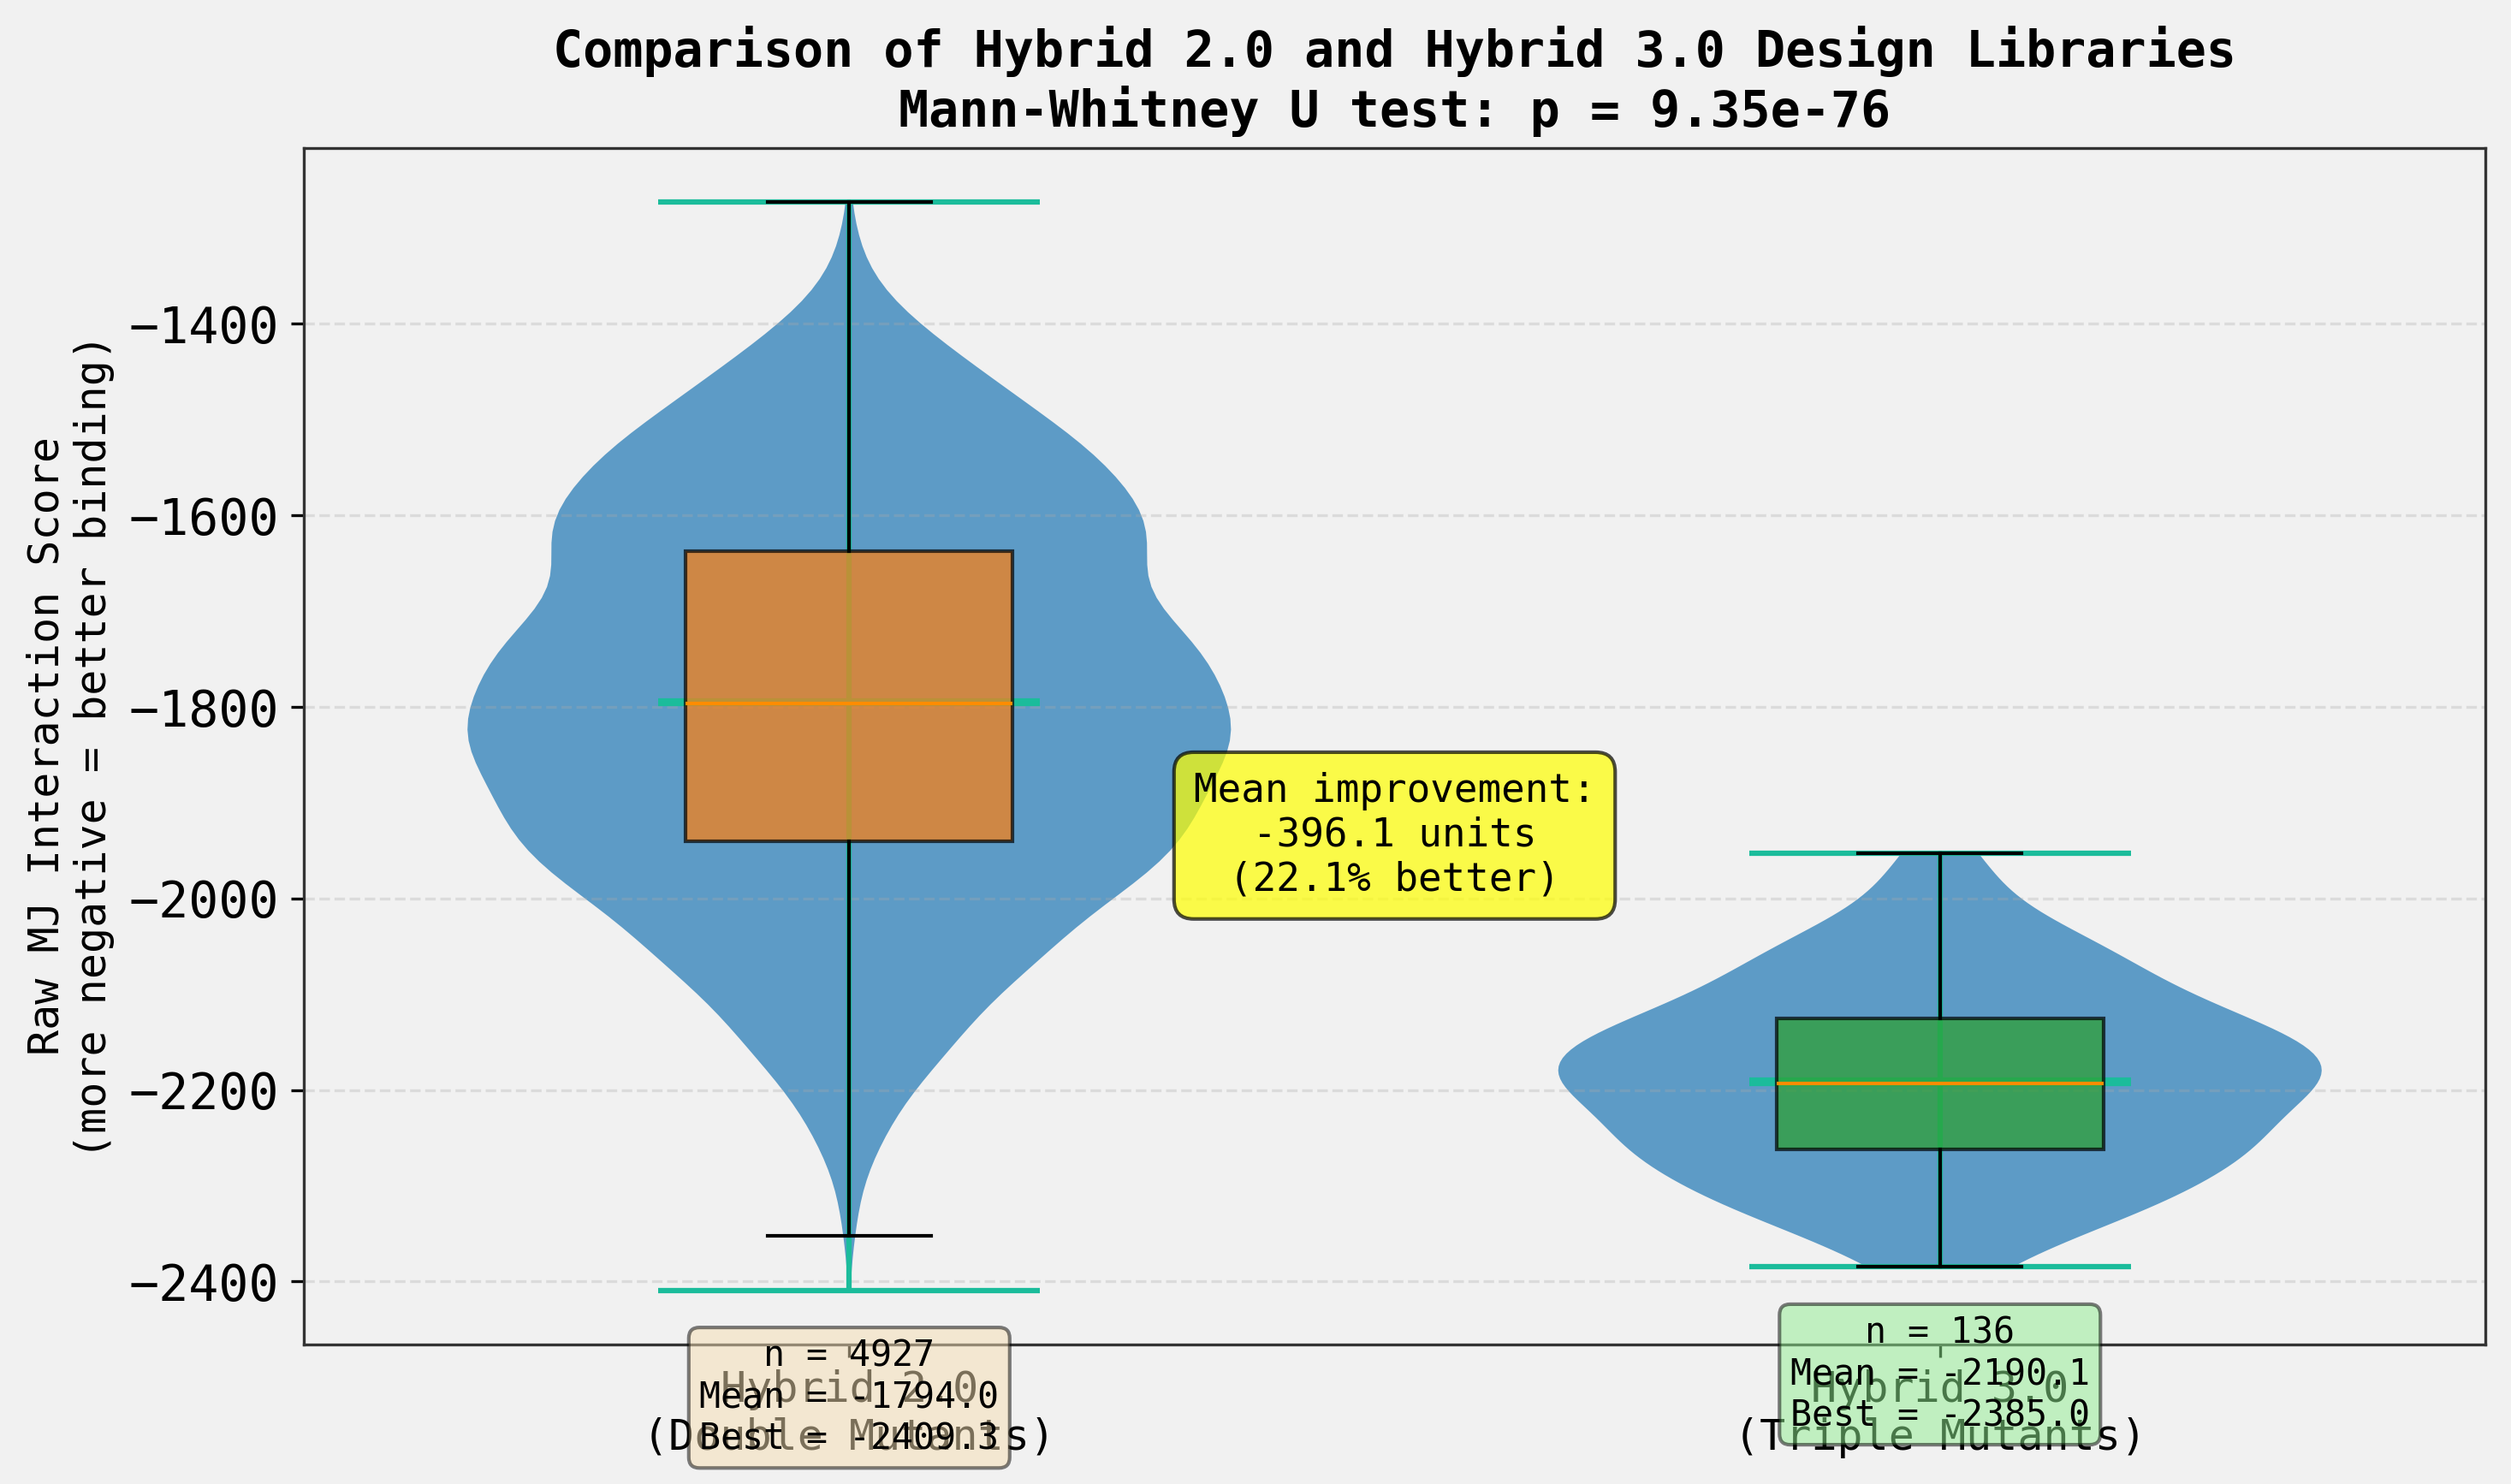


FINAL SUMMARY

Novelty Filter Performance:
  Total triple-mutant variants generated: 152
  Variants passing novelty filter: 152
  Pass rate: 100.0%

Design Library Size:
  Total Hybrid 3.0 designs: 1368
  Unique triple-mutant motifs: 136

Score Comparison (Re-scored with same 413-residue epitope):
  Hybrid 2.0 best score: -2409.27
  Hybrid 3.0 best score: -2384.97
  Hybrid 2.0 mean score: -1793.98
  Hybrid 3.0 mean score: -2190.08
  Mean improvement: -396.10
  Percentage improvement: 22.1%

Statistical Significance:
  Mann-Whitney U p-value: 9.35e-76
  Result: Hybrid 3.0 has SIGNIFICANTLY better scores than Hybrid 2.0 (p < 0.05)


In [ ]:

# Step 21: Create final visualization comparing Hybrid 2.0 and Hybrid 3.0 score distributions
# This will be the key summary figure

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create violin plots for the two distributions
positions = [1, 2]
parts = ax.violinplot([hybrid_2_rescored, hybrid_3_unique_scores], 
                       positions=positions, 
                       showmeans=True, 
                       showmedians=True,
                       widths=0.7)

# Color the violin plots
for pc in parts['bodies']:
    pc.set_facecolor('#1f77b4')
    pc.set_alpha(0.7)

# Add box plots for additional statistics
bp = ax.boxplot([hybrid_2_rescored, hybrid_3_unique_scores], 
                 positions=positions,
                 widths=0.3,
                 patch_artist=True,
                 showfliers=False)

# Color the box plots
for patch, color in zip(bp['boxes'], ['#ff7f0e', '#2ca02c']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Formatting
ax.set_xticks(positions)
ax.set_xticklabels(['Hybrid 2.0\n(Double Mutants)', 'Hybrid 3.0\n(Triple Mutants)'], fontsize=12)
ax.set_ylabel('Raw MJ Interaction Score\n(more negative = better binding)', fontsize=12)
ax.set_title('Comparison of Hybrid 2.0 and Hybrid 3.0 Design Libraries\n' + 
             f'Mann-Whitney U test: p = {p_val:.2e}', fontsize=14, fontweight='bold')

# Add grid for readability
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add statistical annotations
ax.text(1, np.min(hybrid_2_rescored) - 50, 
        f'n = {len(hybrid_2_rescored)}\nMean = {np.mean(hybrid_2_rescored):.1f}\nBest = {np.min(hybrid_2_rescored):.1f}',
        ha='center', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.text(2, np.min(hybrid_3_unique_scores) - 50,
        f'n = {len(hybrid_3_unique_scores)}\nMean = {np.mean(hybrid_3_unique_scores):.1f}\nBest = {np.min(hybrid_3_unique_scores):.1f}',
        ha='center', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# Highlight the significant improvement
improvement = np.mean(hybrid_3_unique_scores) - np.mean(hybrid_2_rescored)
ax.annotate(f'Mean improvement:\n{improvement:.1f} units\n({abs(improvement)/abs(np.mean(hybrid_2_rescored))*100:.1f}% better)',
            xy=(1.5, (np.mean(hybrid_2_rescored) + np.mean(hybrid_3_unique_scores))/2),
            fontsize=11, ha='center',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig('hybrid_3.0_comparison.png', dpi=300, bbox_inches='tight')
print("Figure saved as 'hybrid_3.0_comparison.png'")
plt.show()

# Print final summary
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"\nNovelty Filter Performance:")
print(f"  Total triple-mutant variants generated: {len(triple_mutant_variants)}")
print(f"  Variants passing novelty filter: {len(novel_variants)}")
print(f"  Pass rate: {100 * len(novel_variants) / len(triple_mutant_variants):.1f}%")

print(f"\nDesign Library Size:")
print(f"  Total Hybrid 3.0 designs: {len(hybrid_3_df)}")
print(f"  Unique triple-mutant motifs: {len(hybrid_3_unique_scores)}")

print(f"\nScore Comparison (Re-scored with same 413-residue epitope):")
print(f"  Hybrid 2.0 best score: {np.min(hybrid_2_rescored):.2f}")
print(f"  Hybrid 3.0 best score: {np.min(hybrid_3_unique_scores):.2f}")
print(f"  Hybrid 2.0 mean score: {np.mean(hybrid_2_rescored):.2f}")
print(f"  Hybrid 3.0 mean score: {np.mean(hybrid_3_unique_scores):.2f}")
print(f"  Mean improvement: {np.mean(hybrid_3_unique_scores) - np.mean(hybrid_2_rescored):.2f}")
print(f"  Percentage improvement: {abs(np.mean(hybrid_3_unique_scores) - np.mean(hybrid_2_rescored))/abs(np.mean(hybrid_2_rescored))*100:.1f}%")

print(f"\nStatistical Significance:")
print(f"  Mann-Whitney U p-value: {p_val:.2e}")
print(f"  Result: Hybrid 3.0 has SIGNIFICANTLY better scores than Hybrid 2.0 (p < 0.05)")
